# Getting started with Pyseter

Here we present a quick overview of the main functions of Pyseter with a demo dataset.  

## Installation

If you haven't already, install some form of conda. [Anaconda](https://www.anaconda.com) is probably the easiest to install, but we are personally partial to [miniforge](https://github.com/conda-forge/miniforge?tab=readme-ov-file). Of course, you are also welcome to use any other package management tool, such as [uv](https://docs.astral.sh/uv/), [pixi](https://pixi.sh/latest/), or good old fashioned [venv](https://docs.python.org/3/library/venv.html).

Once you've installed conda, open the command line interface (e.g., the miniforge prompt or the terminal). Then you'll need to do several things:

- Create the conda environment you'll be using
- Active the environment and install `pip`
- Install packages
  - Pytorch, which will depend on your operating system and GPU availability
  - gdown (for downloading the  the dataset)
  - ipykernel (optional, useful if using Jupyter Lab or Jupyter Notebook)
  - pyseter

Below is an example of the commands necessary to install on a Windows machine equipped with an NVIDIA GPU. 

```bash
conda create -n pyseter_env -y  # create new environment 
source activate pyseter_env     # activate it
conda install pip -y            # pip is necessary to install torch and pyseter
pip install torch torchvision --index-url https://download.pytorch.org/whl/cu128 
pip install pyseter gdown ipykernel==6.30.1 ipywidgets
python -m ipykernel install --user --name pyseter_env --display-name "Python (Pyseter)"
```
## Dataset

The images in this example were collected during a multi-year photo-ID survey of spinner dolphins in Hawaiʻi. Every image collected during the study was graded for quality and distinctiveness. This example dataset only includes images of sufficient quality that have been cropped to the identifying mark—the dorsal fin. This example includes 208 images of animals without distinctive markings, and 1043 images of animals with distinctive markings.

Open a Jupyter notebook and download the data with `gdown`, which pulls data from Google Drive.

In [1]:
# import gdown

# # download the demo data
# file_id = '1puM7YBTVFbIAT3xNBQV1g09K0bMGLk1y' 
# file_url = f'https://drive.google.com/uc?id={file_id}'

# gdown.download(file_url, quiet=False, use_cookies=False)

Then, unzip the folder into our `working_directory`. 

In [2]:
# import zipfile
# import shutil

# # extract the files to the working directory
# with zipfile.ZipFile('original_images.zip', 'r') as zip_ref:
#     zip_ref.extractall('working_dir')

# # this is an artifact of zipping on mac 
# shutil.rmtree('working_dir/__MACOSX')

## Working with Pyseter

Now we're ready to work in Pyseter. First, verify that your PyTorch installation. This will also let you know how fast (or slow) you can expect Pyseter to be.

In [3]:
import pyseter
pyseter.verify_pytorch()

✓ PyTorch 2.9.1 detected
✓ Apple Silicon (MPS) GPU available


The demo dataset is organized into subfolders by encounter. 

```
working_dir
└── original_images
    ├── enc0
    │   ├── 0a49385ef8f1e74a.jpg
        ├── 1e105f9659c12a66.jpg
            ...
    │   └── f5093b3089b44e67.jpg
    └── enc12
        ├── 0b5c44f167d89d6c.jpg
        ├── 1e0c186da31a53c4.jpg
            ...
        └── f9bb41e7ce0d672d.jpg
```

Our lives will be a little easier if we do two things: move all these images to a flat folder, i.e., with no subfolders, and create a .csv that indicates which image belongs to which encounter (i.e., a map from image to encounter). The `prep_images()` function does just that.

In [4]:
from pyseter.sort import prep_images

working_dir = 'working_dir'
original_image_dir = working_dir + '/original_images'

# new, flattened directory containing every image
image_dir = working_dir + '/all_images'
prep_images(original_image_dir, all_image_dir=image_dir)

Copied 1251 images to: working_dir/all_images
Saved encounter information to: /Users/PattonP/Library/CloudStorage/OneDrive-SmithsonianInstitution/projects/pyseter/demo/working_dir/encounter_info.csv


### Feature extraction

Identifying animals in images requires extracting feature vectors. The distance between two feature vectors tells us similarity between two images. Similar images likely contain the same individual, if the model is working. 

To do so, we'll initialize the `FeatureExtractor`. The only argument is the batch size, which we recommend setting to something low, like 4. 

In [5]:
import os
from pyseter.extract import FeatureExtractor

# we'll save the results in the feature_dir
feature_dir = working_dir + '/features'
os.makedirs(feature_dir, exist_ok=True)

# initialize the extractor 
fe = FeatureExtractor(batch_size=4)

Using device: mps (Apple Silicon GPU)


Now we can extract features. This will take a while, depending on hardware. On a machine with an NVIDIA GPU, this will take a minute or two. On a Mac, this will take around 10 minutes. Unfortunately, we have not been able to test on a PC without a GPU, but expect it to be slower than 10 minutes.

The first time you extract features with Pyseter, it will download [AnyDorsal](https://besjournals.onlinelibrary.wiley.com/doi/10.1111/2041-210X.14167) to your machine. AnyDorsal is huge (4.5GB), so be prepared! 

In [6]:
# import numpy as np

# features = fe.extract(image_dir=image_dir)

# # this saves the dictionary as an numpy file
# out_path = feature_dir + '/features.npy'
# np.save(out_path, features)

# # convert keys and values to numpy arrays
# filenames = np.array(list(features.keys()))
# feature_array = np.array(list(features.values()))

You can also load in features from a previously saved session. 

In [7]:
# alternatively, load in the feature dictionary from file 
import numpy as np 
from pyseter.sort import load_features
out_path = feature_dir + '/features.npy'
filenames, feature_array = load_features(out_path)

## Clustering individuals

Next, we can cluster individuals into proposed IDs. One simple method for doing so is to say that any two images with similarity scores above a `match_threshold` belong to the same individual (note that the similarity score is one minus the distance between two feature vectors). This creates a network where each node is an image and the connected nodes represent one proposed ID. Hence, we call this `NetworkCluster`

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
from pyseter.sort import NetworkCluster, report_cluster_results

similarity_scores = cosine_similarity(feature_array)
nc = NetworkCluster(match_threshold=0.55)
results = nc.cluster_images(similarity_scores)

Following clusters may contain false positives:
['ID_0001', 'ID_0006', 'ID_0008', 'ID_0021', 'ID_0110']


You can look at the results with `report_cluster_results`.

In [9]:
network_idx = results.cluster_idx
report_cluster_results(network_idx)

Found 208 clusters.
Largest cluster has 128 images.


In an ideal world, every image of the same individual would be connected in the network, and not connected to images of any other individuals. As such, the ideal network would look like a bunch of blobs. As such, we might be suspicious of clusters that look like barbells, i.e., two blobs connected by one link. That one link might be a *false positive*, linking two distinct identities. The `plot_suspicious` function plots things that might look like barbells.

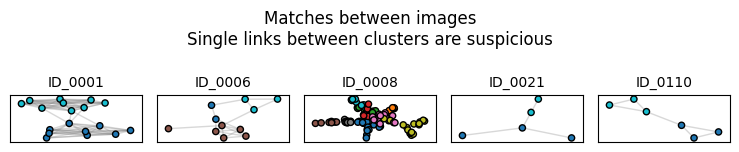

In [10]:
results.plot_suspicious()

## Sorting individuals into folders 

Now, we might want to inspect these proposed ID. One method is to chuck the IDs into a table, i.e., a `DataFrame`.

In [11]:
import pandas as pd

id_df = pd.DataFrame({'image': filenames, 'proposed_id': network_idx})

# join with the encounter information using "encounter" as a key 
encounter_info = pd.read_csv(working_dir + '/encounter_info.csv')
id_df = id_df.merge(encounter_info)
id_df.head()

image proposed_id encounter
0  2c8750b066372ab5.jpg     ID-0000      enc8
1  568fc1d376b616a6.jpg     ID-0001      enc8
2  ddeb347716d7861c.jpg     ID-0002      enc6
3  b65f9334b05f48f4.jpg     ID-0003      enc0
4  d84aefa4d99d6f9a.jpg     ID-0004      enc4

But this isn't particularly satisfying, since we can't actually see the IDs. Probably the easiest way to to sort the images into folders then explore them with the file explore (e.g., Finder on Mac), or with a program like ACDSee. We can do so with `sort_images`.

In [12]:
from pyseter.sort import sort_images

# make an output directory 
sorted_dir = working_dir + '/sorted_images'
os.makedirs(sorted_dir, exist_ok=True)

sort_images(id_df, all_image_dir=image_dir, output_dir=sorted_dir)

Sorted 1251 images into 311 folders.


We can also plot some images with `matplotlib`, if that's your thing.

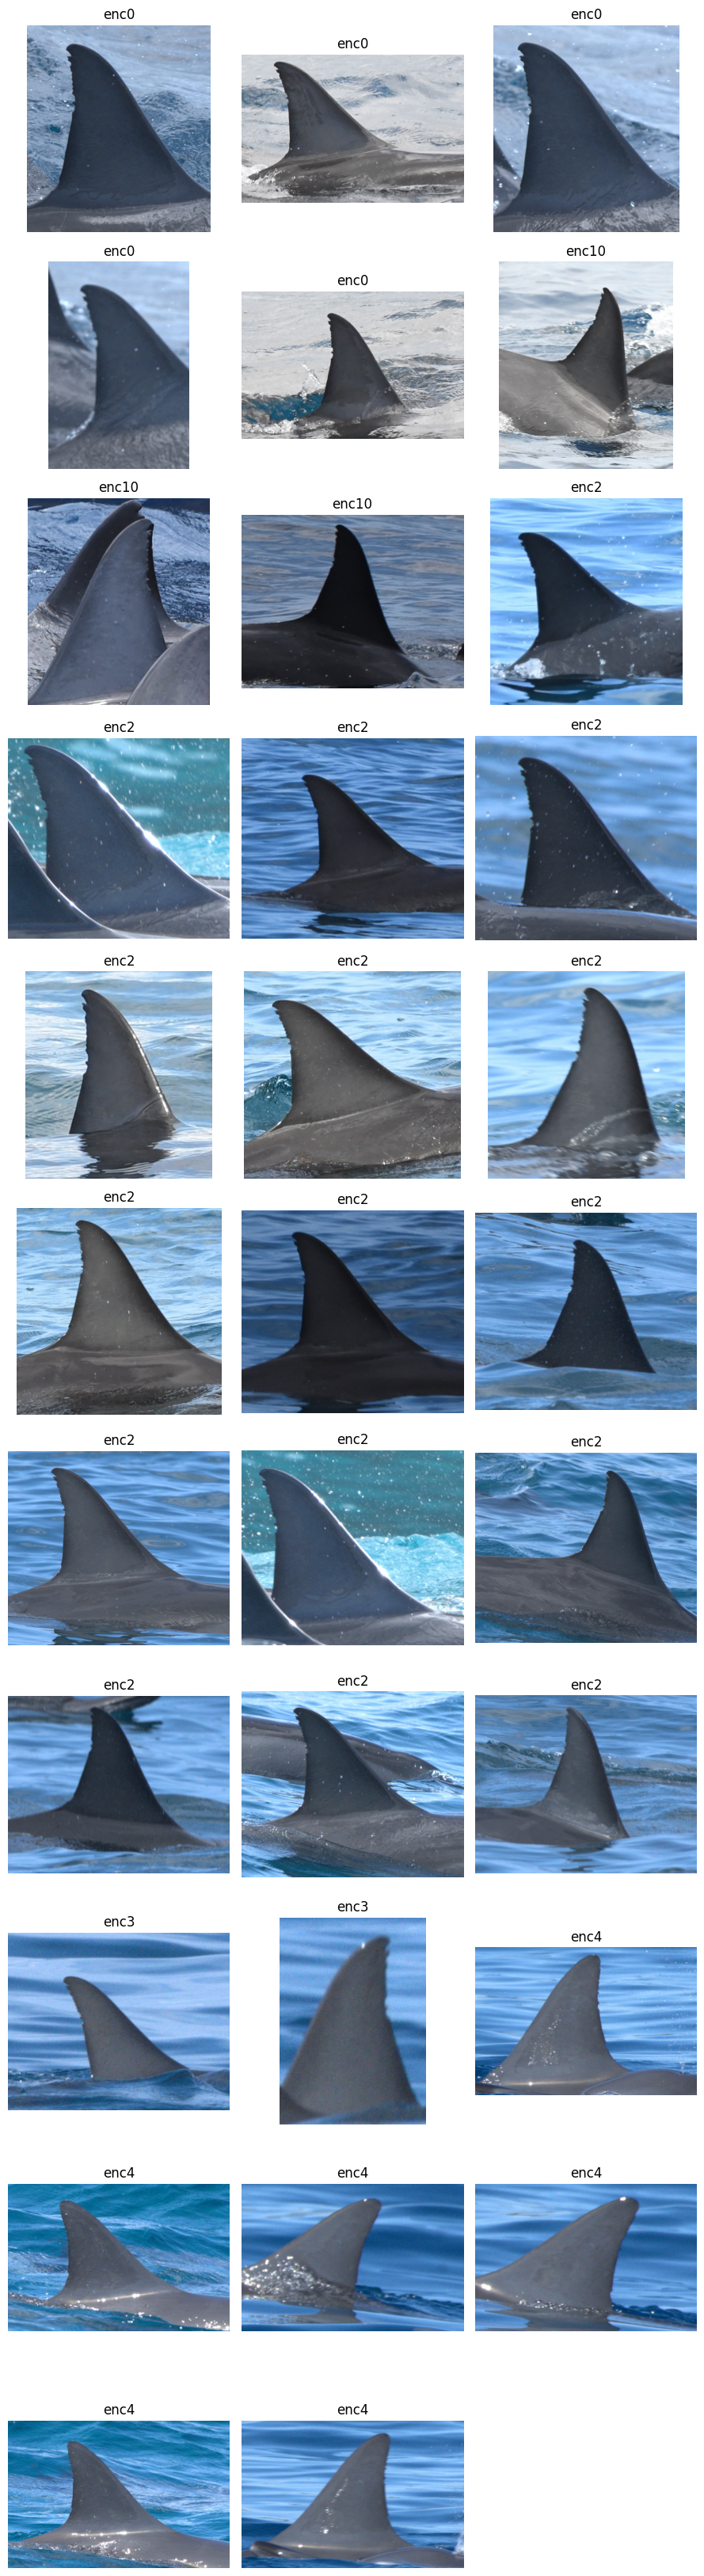

In [13]:
from PIL import Image
import matplotlib.pyplot as plt

# select a random id to plot
rng = np.random.default_rng(seed=17)
random_id = rng.choice(id_df.proposed_id)

# collect all the images for that id
id_info = id_df.loc[id_df.proposed_id == random_id].sort_values('encounter').reset_index(drop=True)
image_count = len(id_info)

# create a figure where each subplot is an image 
column_count = 3
row_count = (image_count + column_count - 1) // column_count
fig, axes = plt.subplots(row_count, column_count, tight_layout=True, 
                         figsize=(9, row_count * 3))

# plot each image
for i, row in id_info.iterrows():
    ax = axes.flat[i]
    path = f'working_dir/all_images/{row.image}'
    image = Image.open(path)
    ax.imshow(image)
    ax.set_title(row.encounter)
    ax.axis('off')

# delete any unnecessary subplots
for i in range(image_count, row_count * column_count):
    axes.flat[i].remove() 